# Assignment 1: Comparison of Regression Models on Predicting Medical Costs

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
![Medical Cost](https://creditkarma-cms.imgix.net/wp-content/uploads/2018/04/boomers-gen-x-high-cost-medical-care.jpg)
In this assignment, you will implement some learning models in the context of a **regression** problem in the [Medical Cost Personal Dataset on Kaggle](https://www.kaggle.com/mirichoi0218/insurance). Specifically, you will attempt to predict the medical cost billed by health insurance using other provided patient's data. For references, you may refer to [my slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit#slide=id.p) or Chapter 4 of the code repo if you need additional sample codes to help with your assignment. To get started, you will need to upload/copy the dataset (.csv) into the same folder as this file. 

For deliverables, you must write code in Colab and submit the downloaded Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.*


***
##  Task 1: SEE THE BIG PICTURE (5 pts)
Write a paragraph explaining the context of the problem in which you are trying to investigate. We will assume that the data file is put into the same workspace on Colab. Then, you can write some code to load the CSV file and take a quick look at the dataset, and output the following:

 * How big is your dataset? (in terms of MB)
 * How many entries does it have?
 * How many features does it have?
 * Does it contain any categorical data?
 * Is there any missing value?
 * What are some basic statistics you can learn right away about this dataset?

## Response



In [150]:
# Import some common packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# to make this notebook's output stable across runs
np.random.seed(42)

# Your code goes here for this section, make sure you also include the output to answer the above questions.
df = pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB


In [0]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


The "Medical Cost Personal Dataset" is a dataframe with 7 features/columns and 1338 entries/rows. It takes up ~73.2 KB in memory.

The features are: **age, sex, bmi, children, smoker, region,** and **charges**. Using the other 6 features, we will use regression to predict **charges**. According to `df.info()`, there are three categorical variables: **sex, smoker,** and **region**. Through `df.describe()`, we can understand the *mean, standard deviation, minimum and maximum values,* and *quantiles* of the quantitative variables. 

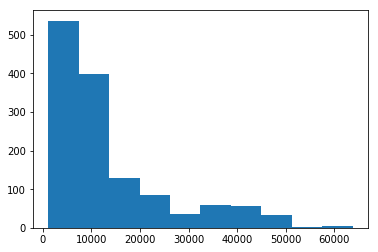

In [0]:
plt.hist(df["charges"])
plt.show()

The output data, **charges**, is skewed-right. In order to predict accurately, we may need to use a log transformation. 


---
##  Task 2: DATA DISCOVERY, CLEANING, AND SCALING (25 pts)

**Data Discover:** Plot out all correlations among the features. You may notice some features are more correlated with your predicted value than other. This information will help you confirm that weights of your regression model later on.

**Data Cleaning:** If your dataset has some missing values, make sure you are able to fill those values with the Imputer class. If your dataset has categorical features, make sure you conver those features into numerical using OneHotEncoder class. 

**Feature Scaling** More importantly, your task is to write some codes to normalize the value of each features as follow:

* Subtract the mean value of each feature from the dataset
* Scale (divide) the feature values by their respective standard deviation

**Implementation Note:** You will need to integrate the above operations into a Pipeline to process and transform the training data, then use the same pipeline to transform any validation and testing data.

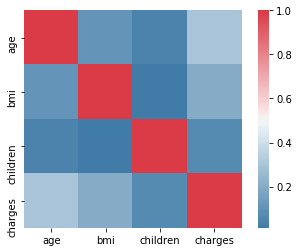

In [152]:
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240,10,as_cmap=True),
            square=True)

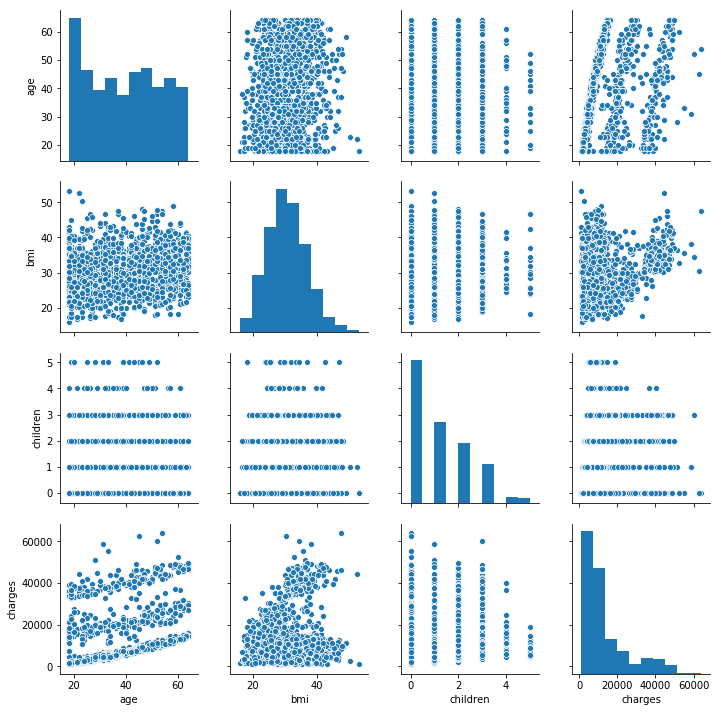

In [153]:
sns.pairplot(df)

In [0]:
# You might want to use the following package
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix # optional
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

# Your code goes here for this section.
train, test = train_test_split(df, test_size=0.2, random_state=42)
len(train)

1070

In [0]:
len(test)

268

In [0]:
# use Pipeline to transform training set
num_trans = Pipeline(steps=[
                           ("scaler", StandardScaler()) 

])
cat_trans = Pipeline(steps=[
                            ("onehot", OneHotEncoder(handle_unknown = "ignore"))
])

numeric_features = train.select_dtypes(include=[float, int]).drop("charges", axis=1).columns # do not transform "charges" 
categorical_features = train.select_dtypes(include=[object]).columns

prep = ColumnTransformer(transformers=[
                                       ("num", num_trans, numeric_features), 
                                       ("cat", cat_trans, categorical_features)
])

In [0]:
X_train = train.drop("charges", axis=1)
X_test = test.drop("charges", axis=1)
y_train = train["charges"].copy()
y_test = test["charges"].copy()

- - -
## Task 3. IMPLEMENT GRADIENT DESCENT (30 pts)
The gradient descent formulation remain the same as one in the lecture. Keep in mind that you will need to add a column $\textbf{x}_0$ with all 1s as part of the training data. You should write code to implement the **MyLinearRegression** class and its predefined methods. 

**Gradient Descent:** Notes that you may NOT call the library linear regression which defeats the purpose of this assignment. Make sure your code is well-vectorized.

In [129]:
# NOTE: You may not use the library Linear Regression, but implement your own!
# REMEMBER to place self.attribute = 0 with value from your implementation

class MyLinearRegression:
  """
  Define what a linear regressor can do
  """
  def __init__ (self, learning_rate=0.005):
    """
    Initialize the regressor
    """
    self.theta = 0; # parameter vector;
    self.alpha = learning_rate; # learning rate
    self.cost  = 0; # cost function

  def gradientDescent(self, X_train, y_train, theta, alpha, iters):
    """
    Implementatation of the gradient descent
    INPUT:
    alpha: the learning rate
    iters: number of iterations

    OUTPUT: 
    theta: updated value for theta
    cost: value of the cost function
    """
    # implementation code here
    X = np.concatenate([np.ones((len(X_train), 1)), X_train], axis=1)
    transpose = X.transpose()
    costs = []
    weights = np.zeros(X.shape[1], dtype=int)
    
    for i in range(iters): 
      h = np.dot(X, weights)  # find the hypothesis/predictions
      c = h - y_train 
      g = np.dot(transpose, c)
      g = g / len(y_train)
      weights = weights - alpha*g

      current_cost = np.absolute(c).sum()
      costs.append(current_cost)
      
    return weights, costs

  def fitUsingGradientDescent(self, X_train, y_train):
    """
    Train the regressor using gradient descent
    """
    # implementation code here

    t, c = self.gradientDescent(X_train, y_train, self.theta, self.alpha, iters=1000)
    self.theta = t
    self.cost = c

    return self
  
  def fitUsingNormalEquation(self, X_train, y_train):
    """
    Training using the Normal (close form) equation
    """
    # implementation code here for Task 4.

    X = np.concatenate([np.ones((len(X_train), 1)), X_train], axis=1)
    transpose_x = X.transpose()
    optimal_theta = np.dot(np.linalg.inv(np.dot(transpose_x, X)), np.dot(transpose_x, y_train))
    self.theta = optimal_theta
    
    return self
  
  def fit(self, X_train, y_train, model_type="gd"):
    # to make Pipeline work smoooothly
    if model_type == "gd": 
      return self.fitUsingGradientDescent(X_train, y_train)
    else:
      return self.fitUsingNormalEquation(X_train, y_train)

  def predict(self, X_test):
    """
    Predicting the label
    """
    # implementation code here

    X = np.concatenate([np.ones((len(X_test), 1)), X_test], axis=1)
    y_predict = np.dot(X, self.theta)
    
    return y_predict

  def __str__(self):
    """
    Print out the parameter out when call print()
    """
    return("Parameter vector is %f" % self.theta)
    
# Your code goes here to call the instance of class MyLinearRegression
myGradientDescentModel = MyLinearRegression()
mlr = Pipeline(steps=[
                      ("prep", prep), 
                      ("model", myGradientDescentModel) 
                      ])
#  using model__ allows to access specific parameters in "model" step
mlr.fit(X_train, y_train, model__model_type="gd") 

Pipeline(memory=None,
         steps=[('prep',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['age', 'bmi', 'children'], dtype='object')),
                                                 ('cat',
                                      

In [0]:
from sklearn.model_selection import cross_val_score


In [0]:
# predict
y_predict = mlr.predict(X_test)
"""
scores = cross_val_score(mlr, X_test, y_test,
                             scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
"""

In [140]:
lin_mse = mean_squared_error(y_test, y_predict)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

5802.816675931879

* **Learning Rate:** You will try out different learning rates for the dataset and find a learning rate that converges quickly. If you pick a learning rate, your plot of Cost Function $J(\theta)$ against number of iteration will quickly decay to a small value. This also indicates that your implementation is correct. If your learning rate is too large, the cost function $J(\theta)$ can diverge and blow up. From the below plot, you must be able to report the best learning rate the you found to earn credit for this section.

Text(0.5, 1.0, 'Error vs. Training Iterations')

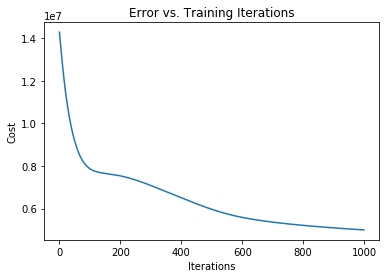

In [125]:
# Use the following code to plot out your learning rate
# iters and cost must be supplied to plot out the cost function
# You may plot multiple curves corresponding to different learning rates to justify the best one.
#
plt.plot(myGradientDescentModel.cost)
plt.xlabel('Iterations')  
plt.ylabel('Cost')  
plt.title('Error vs. Training Iterations')  

- - -
## Task 4. IMPLEMENT THE NORMAL EQUATION (10 pts)

In my lecture, you learn that the closed form solution of linear regression using the normal equation formulation. Using the formula does not require any feature scaling, and should be straight forward to implement: 

$
    \mathbf{\theta} = ({\mathbf{X}^{T}\mathbf{X}})^{-1}\mathbf{X}^{T}\mathbf{y}.
$

Note that you still need to add a column of 1's to the $\mathbf{
X}$ matrix to have an intercept term.

In [130]:
# Implement the normalEquation method of the MyLinearRegression Class before execute the code below:
myNormalEquationModel = MyLinearRegression()

mnem = Pipeline(steps=[
                      ("prep", prep), 
                      ("model", myNormalEquationModel) 
                      ])
#  using model__ allows to access specific parameters in "model" step
mnem.fit(X_train, y_train, model__model_type="else") 

Pipeline(memory=None,
         steps=[('prep',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['age', 'bmi', 'children'], dtype='object')),
                                                 ('cat',
                                      

In [137]:
y_predict_normal = mnem.predict(X_test)

"""
scores_normal = cross_val_score(mnem, X_test, y_test,
                             scoring="neg_mean_squared_error", cv=10)
rmse_scores_normal = np.sqrt(-scores_normal)
rmse_scores_normal
"""
mnem_mse = mean_squared_error(y_test, y_predict_normal)
mnem_rmse = np.sqrt(mse)
mnem_rmse

5802.816675931879

- - -
## Task 5. COMPARE DIFFERENT IMPLEMENTATIONS (20 pts)

You should be able to evaluate and compare your gradient descent as well as normal equation implementation of linear regression. In theory, they should be the same, or at least similar. For good measures, you may also use the built-in library **Scholastic Gradient Descent (SGD)** as a third model for comparison. For each model, you must compute the RMSE on the **test set** as performance measure. The good news is that you can call library functions to compute these as shown below instead of writing your own code:

* Which one yields the best performance measure for your dataset?
* What is your assessment of the error? Good? Okay? Terrible?

In [139]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor

# Use the built-in SGD Regressor model

mySGDModel = SGDRegressor()
sgd = Pipeline(steps=[
                      ("prep", prep), 
                      ("model", mySGDModel) 
                      ])
sgd.fit(X_train, y_train)
y_predict_sgd = sgd.predict(X_test)
mse_sgd = mean_squared_error(y_test, y_predict_sgd)
mySGDModel_rmse = np.sqrt(mse_sgd)

print(mySGDModel_rmse)

5791.118754853963


In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

In [142]:
# use built in Random Forest Regressor

rfr = Pipeline(steps=[
                      ("prep", prep), 
                      ("model", RandomForestRegressor()) 
                      ])
rfr.fit(X_train, y_train)
y_predict_rfr = rfr.predict(X_test)
mse_rfr = mean_squared_error(y_test, y_predict_rfr)
rmse_rfr = np.sqrt(mse_rfr)
rmse_rfr

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


4935.371345585616

In [144]:
# use built in Decision Tree Regressor

dtr = Pipeline(steps=[
                      ("prep", prep), 
                      ("model", DecisionTreeRegressor()) 
                      ])
dtr.fit(X_train, y_train)
y_predict_dtr = dtr.predict(X_test)
mse_dtr = mean_squared_error(y_test, y_predict_dtr)
rmse_dtr = np.sqrt(mse_dtr)
rmse_dtr

6680.7460978857025

In [145]:
sci_linear = Pipeline(steps=[
                      ("prep", prep), 
                      ("model", LinearRegression()) 
                      ])
sci_linear.fit(X_train, y_train)
y_predict_sci_linear = sci_linear.predict(X_test)
mse_sci_linear = mean_squared_error(y_test, y_predict_sci_linear)
rmse_sci_linear = np.sqrt(mse_sci_linear)
rmse_sci_linear

5796.2846592762735

In [148]:
figure1 = pd.DataFrame({"MyLinearRegression":[lin_rmse], 
              "Scikit-learn Linear Regression":[rmse_sci_linear] , 
              "Normal Equation":[mnem_rmse], 
              "Stochastic Gradient Descent": mySGDModel_rmse, 
              "Decision Tree Model": rmse_dtr, 
              "Random Forest Regressor": rmse_rfr}, index=["rmse score"])
figure1

,MyLinearRegression,Scikit-learn Linear Regression,Normal Equation,Stochastic Gradient Descent,Decision Tree Model,Random Forest Regressor
rmse score,5802.816676,5796.284659,5802.816676,5791.118755,6680.746098,4935.371346


- - -
## Task 6. PRESENT YOUR SOLUTION (10 pts)

Now that you need to write a short memo of one paragraph to be read by a non-technical audience (ie. your manager/boss). Focus on answering the following: 

* How can you pitch your solution to this project? 
* What did you learn so far about the problem?
* Is there any insight moving forward to improve the solution.

**MY ANSWER:**

The model with the smallest root-mean-squared-error was the **Random Forest Regressor** (see `figure1`.) **Stochastic Gradient Descent** also performed better than the Linear Regression models (both mine and scikit-learn's.) 

In order to perform better, we need to ensure that the quantitative and qualitative variables are treated differently (see `prep` transformer.) Take the `bmi` feature for instance; it should not be viewed in the same way as the `smoker` feature is. 

The problem assessed different features in order to predict `charges` in hospitals. In the pairplot, we can see different features have a higher correlation than other features. For example, compare `age` and `bmi`. 

However, even though the Random Forest Regressor had teh smallest error, it still had a large rmse value of ~4900. This still can be considered significant, especially because the results of the data analysis is probably more relevant to those with lower incomes. 

In order to understand which features impact the `charges` value better, we should use a GridSearchCV to optimize the parameters within the Linear Regression model itself. This could include the learning rate (alpha.) And as always, we could improve the model with a larger dataset. 

- - - 
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my [slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit?usp=sharing) and/or the textbook
 * Talk to the TA, they are available and there to help you during [office hour](http://bit.ly/cs4774oh)
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 1:...".

Best of luck and have fun!